#Import

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.15.0


# Loading the Dataset

In [2]:
cifar10 = keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels)= cifar10.load_data()
(val_images, val_labels) = (train_images[0:10000], train_labels[0:10000])
(train_images, train_labels) = (train_images[10000:50000], train_labels[10000:50000])

170500096/170498071 [==============================] - 7s 0us/step


# Data Preprocessing

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

print("train_images.shape", train_images.shape)
print("length of train_labels",len(train_labels))

print("val_images.shape", val_images.shape)
print("length of val_labels",len(val_labels))


test_images=test_images[1:9985]
print("test_images.shape",test_images.shape)

test_labels=test_labels[1:9985]
print("length of test_labels",len(test_labels))


train_images.shape (40000, 32, 32, 3)
length of train_labels 40000
val_images.shape (10000, 32, 32, 3)
length of val_labels 10000
test_images.shape (9984, 32, 32, 3)
length of test_labels 9984


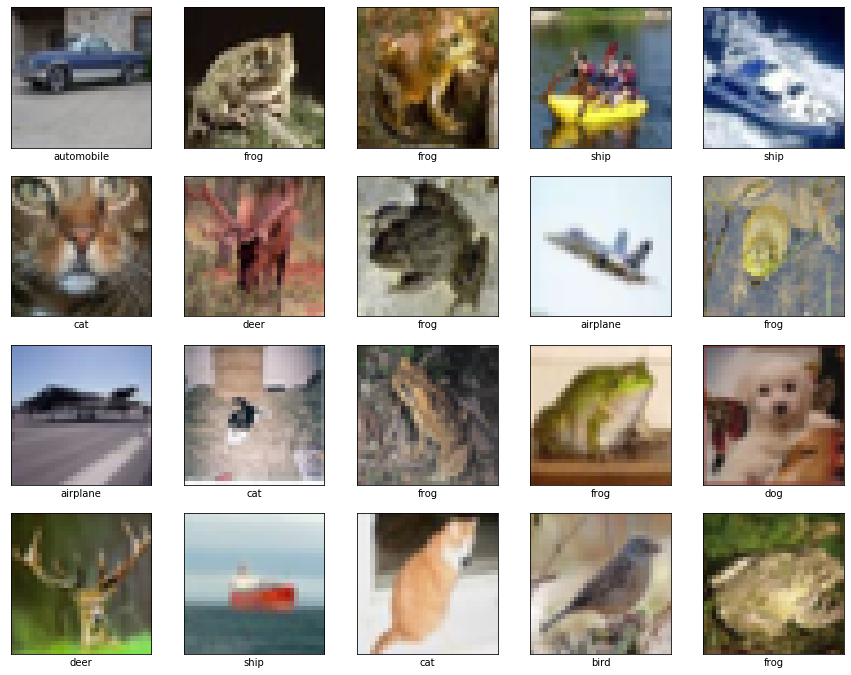

In [4]:
plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[int(train_labels[i])])
plt.show()

# CNN Model

In [5]:
multiworker_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL)
with multiworker_strategy.scope():
  model = tf.keras.Sequential([

      tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(32,32,3)),
      tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.AveragePooling2D((2,2)),

      tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
      tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
      tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.Conv2D(1024, (3,3), padding='same', activation='relu'),
      tf.keras.layers.Conv2D(1024, (3,3), padding='same', activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(4096,activation='relu'),
      tf.keras.layers.Dense(256,activation='relu'),
      tf.keras.layers.Dense(128,activation='relu'),
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dense(64,activation='relu'),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)
  ])
  


  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=15)

INFO:tensorflow:Single-worker CollectiveAllReduceStrategy with local_devices = ('/device:GPU:0',), communication = CollectiveCommunication.NCCL
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 1250 steps
Epoch 1/15
1250/1250 [==============================] - 29s 23ms/step - loss: 1.6395 - acc: 0.3903
Epoch 2/15
1250/1250 [==============================] - 25s 20ms/step - loss: 1.1494 - acc: 0.5913
Epoch 3/15
1250/1250 [==============================] - 25s 20ms/step - loss: 0.9071 - acc: 0.6862
Epoch 4/15
1250/1250 [==============================] - 25s 20ms/step - loss: 0.7269 - acc: 0.7545
Epoch 5/15
1250/1250 [==============================] - 25s 20ms/step - loss: 0.5932 - acc: 0.8022
Epoch 6/15
1250/1250 [==============================] - 25s 20ms/step - loss: 0.4753 - acc: 0.8424
Epoch 7/15
1250/1250 [==============================] - 25s 20ms/step - loss: 0.3607 - acc: 0.8813
Epoch 8/15
1250/1250 [==============================] - 25s 20

# Testing Model

In [6]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

312/312 [==============================] - 2s 7ms/step - loss: 0.9120 - acc: 0.7938
Test accuracy: 0.79377


In [7]:
predictions = model.predict(test_images)
print(predictions[0])
print(np.argmax(predictions[0]))


[4.0597873e-04 2.3783259e-04 5.9027849e-07 1.9953732e-06 1.5325882e-06
 4.3922205e-07 4.9694495e-07 1.4243903e-07 9.9934322e-01 7.6979313e-06]
8


# Plotting the predictions

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

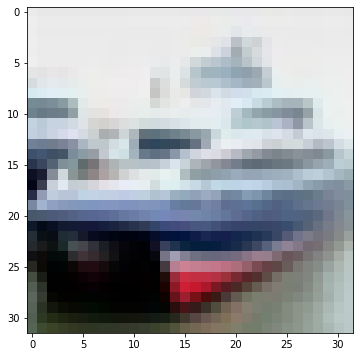

[8]
ship


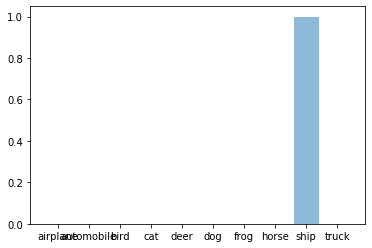

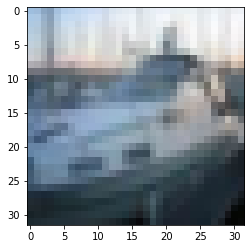

[8]
ship


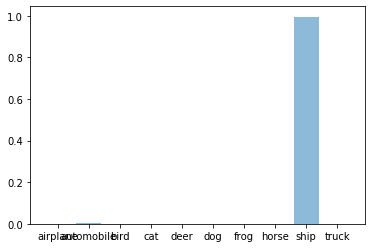

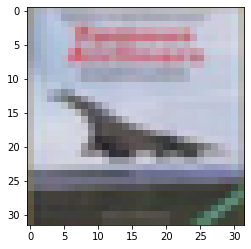

[0]
airplane


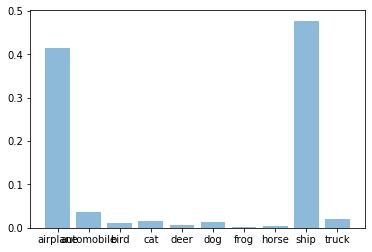

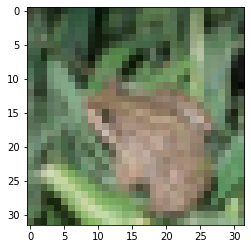

[6]
frog


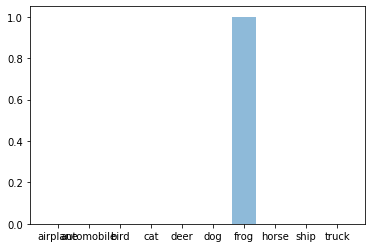

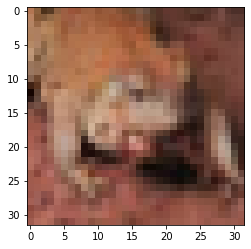

[6]
frog


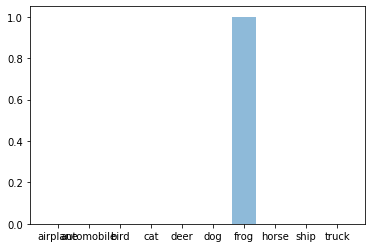

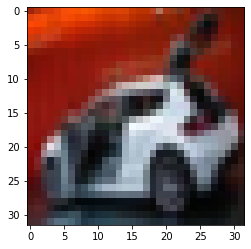

[1]
automobile


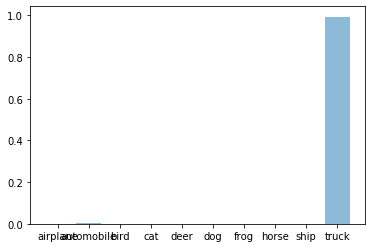

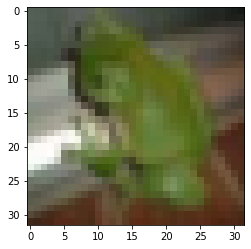

[6]
frog


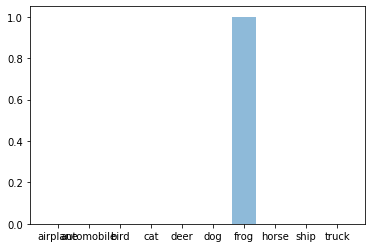

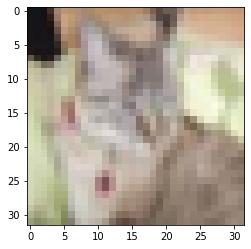

[3]
cat


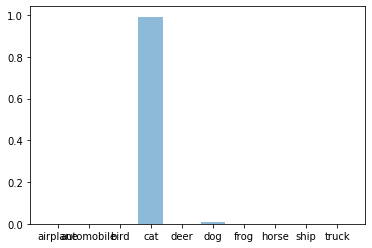

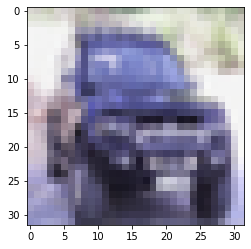

[1]
automobile


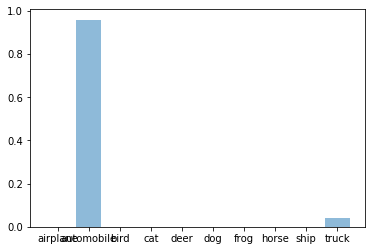

In [9]:

num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.imshow(test_images[i])
  plt.show()
  print(test_labels[i])
  print(class_names[int(test_labels[i])])
  #print(predictions[i,:])
  plt.bar(class_names, predictions[i,:], align='center', alpha=0.5)
  plt.show()

